In [3]:
!pip install autogluon --quiet


In [7]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("Mahadih534/Global_Environment-Social-And-Governance-Data")
df = dataset['train'].to_pandas()

# Filter for Mongolia only
df_mng = df[df["Country Name"]=="Mongolia"]

print(df_mng[["Indicator Name","Indicator Code"]].drop_duplicates().head(20))


                                          Indicator Name     Indicator Code
11431  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS
11432            Access to electricity (% of population)     EG.ELC.ACCS.ZS
11433  Adjusted savings: natural resources depletion ...  NY.ADJ.DRES.GN.ZS
11434  Adjusted savings: net forest depletion (% of GNI)  NY.ADJ.DFOR.GN.ZS
11435                 Agricultural land (% of land area)     AG.LND.AGRI.ZS
11436  Agriculture, forestry, and fishing, value adde...     NV.AGR.TOTL.ZS
11437  Annual freshwater withdrawals, total (% of int...     ER.H2O.FWTL.ZS
11438  Annualized average growth rate in per capita r...     SI.SPR.PCAP.ZG
11439  Cause of death, by communicable diseases and m...     SH.DTH.COMM.ZS
11440  Children in employment, total (% of children a...     SL.TLF.0714.ZS
11441             CO2 emissions (metric tons per capita)     EN.ATM.CO2E.PC
11442                                 Coastal protection     EN.CLC.CSTP.ZS
11443       

In [8]:
# Filter for renewable share + energy intensity
codes = ["EG.FEC.RNEW.ZS","EG.EGY.PRIM.PP.KD"]
mng_indicators = df_mng[df_mng["Indicator Code"].isin(codes)]


In [9]:
# All year columns
year_cols = [c for c in mng_indicators.columns if c.isdigit()]

mng_long = mng_indicators.melt(
    id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

mng_long["Year"] = mng_long["Year"].astype(int)
mng_long = mng_long.dropna(subset=["Value"])
print(mng_long.head())


   Country Name Country Code  \
61     Mongolia          MNG   
63     Mongolia          MNG   
65     Mongolia          MNG   
67     Mongolia          MNG   
69     Mongolia          MNG   

                                       Indicator Name  Indicator Code  Year  \
61  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1990   
63  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1991   
65  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1992   
67  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1993   
69  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1994   

    Value  
61   1.89  
63   1.97  
65   2.40  
67   2.67  
69   3.04  


In [10]:
ts = mng_long.pivot(index="Year", columns="Indicator Code", values="Value")
ts.rename(columns={
    "EG.FEC.RNEW.ZS":"RenewableShare",
    "EG.EGY.PRIM.PP.KD":"EnergyIntensity"
}, inplace=True)

ts = ts.sort_index()
print(ts.head())


Indicator Code  EnergyIntensity  RenewableShare
Year                                           
1990                        NaN            1.89
1991                        NaN            1.97
1992                        NaN            2.40
1993                        NaN            2.67
1994                        NaN            3.04


In [11]:
print(ts.isna().sum())
print(ts.head(15))   # see where the gaps are


Indicator Code
EnergyIntensity    10
RenewableShare      0
dtype: int64
Indicator Code  EnergyIntensity  RenewableShare
Year                                           
1990                        NaN            1.89
1991                        NaN            1.97
1992                        NaN            2.40
1993                        NaN            2.67
1994                        NaN            3.04
1995                        NaN            3.01
1996                        NaN            3.44
1997                        NaN            3.39
1998                        NaN            3.74
1999                        NaN            3.59
2000                       9.25            5.73
2001                       9.06            6.09
2002                       9.26            6.51
2003                       8.45            6.09
2004                       7.87            5.76


In [12]:
ts_interp = ts.interpolate(method="linear")


In [13]:
ts_interp = ts_interp.fillna(method="bfill").fillna(method="ffill")


/tmp/ipython-input-1259654024.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_interp = ts_interp.fillna(method="bfill").fillna(method="ffill")


Indicator Code
EnergyIntensity    0
RenewableShare     0
dtype: int64


<Axes: title={'center': 'Mongolia Energy Indicators'}, xlabel='Year'>

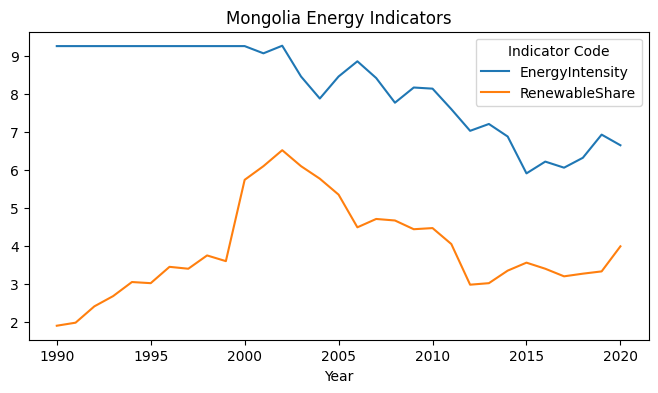

In [14]:
print(ts_interp.isna().sum())
ts_interp.plot(title="Mongolia Energy Indicators", figsize=(8,4))


In [15]:
!pip install autogluon --quiet

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [16]:
# Renewable energy share
renewable = ts_interp[['RenewableShare']].reset_index()
renewable['item_id'] = 'RenewableShare'
renewable.rename(columns={'Year':'timestamp','RenewableShare':'target'}, inplace=True)

# Energy intensity
intensity = ts_interp[['EnergyIntensity']].reset_index()
intensity['item_id'] = 'EnergyIntensity'
intensity.rename(columns={'Year':'timestamp','EnergyIntensity':'target'}, inplace=True)

# Combine
long_df = pd.concat([renewable, intensity], ignore_index=True)

ts_df = TimeSeriesDataFrame.from_data_frame(
    long_df,
    id_column='item_id',
    timestamp_column='timestamp'
)

print(ts_df.head())


Indicator Code                                target
item_id        timestamp                            
RenewableShare 1970-01-01 00:00:00.000001990    1.89
               1970-01-01 00:00:00.000001991    1.97
               1970-01-01 00:00:00.000001992    2.40
               1970-01-01 00:00:00.000001993    2.67
               1970-01-01 00:00:00.000001994    3.04


In [17]:
train_data, test_data = ts_df.train_test_split(prediction_length=5)


Sorting the dataframe index before generating the train/test split.


In [20]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor(
    prediction_length=5,
    target="target",
    eval_metric="RMSE",
    path="ag_ts_output_v2",   # new path so it doesn’t clash
    verbosity=2
)

predictor.fit(
    train_data,
    hyperparameters={
        "ARIMA": {},
        "ETS": {},
        "DirectTabular": {}  # ML-style predictor
    }
)


Beginning AutoGluon training...
AutoGluon will save models to '/content/ag_ts_output_v2'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.36 GB / 12.67 GB (89.6%)
Disk Space Avail:   62.46 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'ARIMA': {}, 'DirectTabular': {}, 'ETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'ns'
Provided train_data has 52 rows, 2 time series. Median time series length

In [23]:
# Get leaderboard and derive RMSE from score_test (it's negated)
lb = predictor.leaderboard(test_data, silent=True)

summary = lb[['model','score_test']].copy()
summary['RMSE'] = -summary['score_test']   # flip sign to get actual RMSE
summary = summary[['model','RMSE']].sort_values('RMSE')

print(summary)
summary.to_csv("model_comparison_rmse.csv", index=False)


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


              model      RMSE
0               ETS  0.484898
1  WeightedEnsemble  0.518818
2             ARIMA  0.518818
3     DirectTabular  1.521062


In [28]:
forecasts = predictor.predict(ts_df)
print(forecasts.head())


Model not specified in predict, will default to the model with the best validation score: ARIMA


                                                  mean       0.1       0.2  \
item_id        timestamp                                                     
RenewableShare 1970-01-01 00:00:00.000002021  4.098551  3.390395  3.633491   
               1970-01-01 00:00:00.000002022  4.164138  3.071963  3.446885   
               1970-01-01 00:00:00.000002023  4.200424  2.785389  3.271142   
               1970-01-01 00:00:00.000002024  4.220498  2.523104  3.105785   
               1970-01-01 00:00:00.000002025  4.231604  2.282358  2.951495   

                                                   0.3       0.4       0.5  \
item_id        timestamp                                                     
RenewableShare 1970-01-01 00:00:00.000002021  3.808779  3.958557  4.098551   
               1970-01-01 00:00:00.000002022  3.717229  3.948229  4.164138   
               1970-01-01 00:00:00.000002023  3.621403  3.920689  4.200424   
               1970-01-01 00:00:00.000002024  3.525939  3.88494

In [31]:
hist_df = ts_df.reset_index()
fc_df   = forecasts.reset_index()

print(hist_df.head())
print(fc_df.head())


Indicator Code         item_id                     timestamp  target
0               RenewableShare 1970-01-01 00:00:00.000001990    1.89
1               RenewableShare 1970-01-01 00:00:00.000001991    1.97
2               RenewableShare 1970-01-01 00:00:00.000001992    2.40
3               RenewableShare 1970-01-01 00:00:00.000001993    2.67
4               RenewableShare 1970-01-01 00:00:00.000001994    3.04
          item_id                     timestamp      mean       0.1       0.2  \
0  RenewableShare 1970-01-01 00:00:00.000002021  4.098551  3.390395  3.633491   
1  RenewableShare 1970-01-01 00:00:00.000002022  4.164138  3.071963  3.446885   
2  RenewableShare 1970-01-01 00:00:00.000002023  4.200424  2.785389  3.271142   
3  RenewableShare 1970-01-01 00:00:00.000002024  4.220498  2.523104  3.105785   
4  RenewableShare 1970-01-01 00:00:00.000002025  4.231604  2.282358  2.951495   

        0.3       0.4       0.5       0.6       0.7       0.8       0.9  
0  3.808779  3.958557  4.

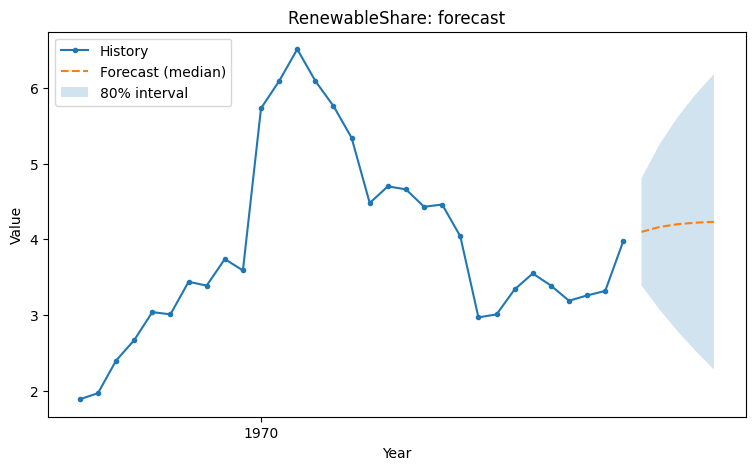

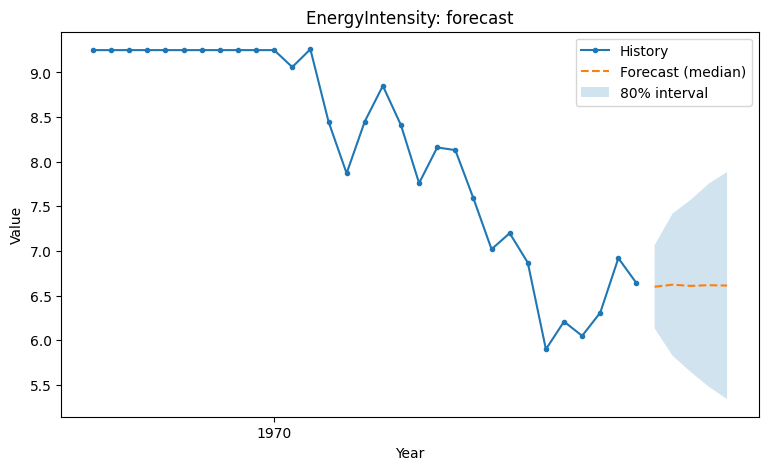

In [32]:
import matplotlib.pyplot as plt

for item in hist_df['item_id'].unique():
    h = hist_df[hist_df['item_id']==item]
    f = fc_df[fc_df['item_id']==item]

    plt.figure(figsize=(9,5))
    plt.plot(h['timestamp'], h['target'], '.-', label='History')
    if '0.5' in f.columns:
        plt.plot(f['timestamp'], f['0.5'], '--', label='Forecast (median)')
    if '0.1' in f.columns and '0.9' in f.columns:
        plt.fill_between(f['timestamp'], f['0.1'], f['0.9'], alpha=0.2, label='80% interval')
    plt.title(f'{item}: forecast')
    plt.xlabel('Year'); plt.ylabel('Value'); plt.legend()
    plt.show()


In [33]:
forecast_table = fc_df.rename(columns={'0.5':'forecast_median','0.1':'forecast_p10','0.9':'forecast_p90'})
forecast_table.to_csv("mongolia_forecasts.csv", index=False)
print("Saved mongolia_forecasts.csv")


Saved mongolia_forecasts.csv


Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/content/ag_ts_output_2030'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.22 GB / 12.67 GB (88.5%)
Disk Space Avail:   62.43 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'ARIMA': {}, 'DirectTabular': {}, 'ETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 9,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'

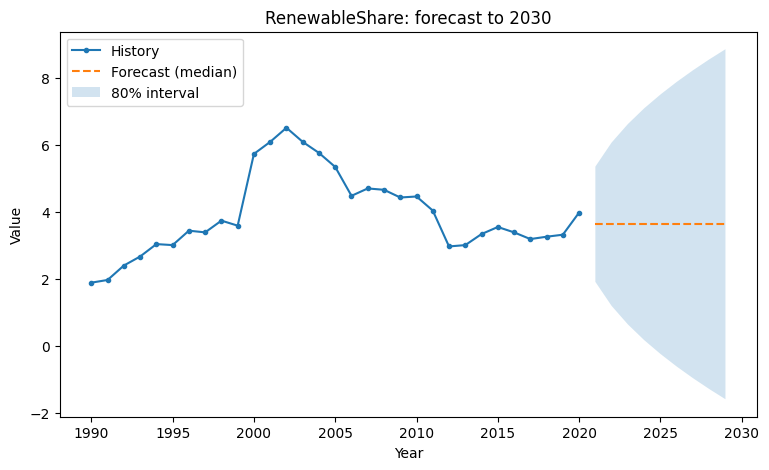

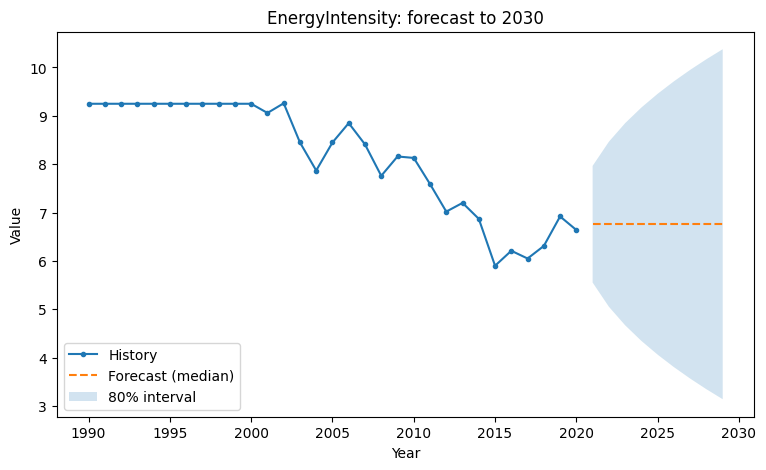

Saved mongolia_forecasts_2022_2030.csv


In [34]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

# 1) Keep the window you want to learn on (e.g., 1990–2021)
ts2 = ts_interp.loc[1990:2021].copy()          # ts_interp has columns: RenewableShare, EnergyIntensity
ts2.index.name = "Year"

# 2) Convert Year -> true datetimes (end of year)
ts2["timestamp"] = pd.to_datetime(ts2.index.astype(str), format="%Y")

# 3) Build long format with proper timestamps
ren = ts2[["timestamp","RenewableShare"]].rename(columns={"RenewableShare":"target"})
ren["item_id"] = "RenewableShare"

intn = ts2[["timestamp","EnergyIntensity"]].rename(columns={"EnergyIntensity":"target"})
intn["item_id"] = "EnergyIntensity"

long_df = pd.concat([ren, intn], ignore_index=True)[["item_id","timestamp","target"]]

ts_df = TimeSeriesDataFrame.from_data_frame(long_df, id_column="item_id", timestamp_column="timestamp")

# 4) Split & fit with 9-year horizon (2022–2030)
train_data, test_data = ts_df.train_test_split(prediction_length=9)

predictor = TimeSeriesPredictor(
    prediction_length=9, target="target", eval_metric="RMSE", path="ag_ts_output_2030"
)
predictor.fit(
    train_data,
    hyperparameters={
        "ARIMA": {},
        "ETS": {},
        "DirectTabular": {}
    }
)

# 5) Forecast to 2030
forecasts = predictor.predict(ts_df)  # returns quantiles 0.1..0.9; 0.5 = median

# 6) Plot: history + median + 80% band for each series
hist_df = ts_df.reset_index()               # cols: item_id, timestamp, target
fc_df   = forecasts.reset_index()           # cols: item_id, timestamp, 0.1, ..., 0.5, ..., 0.9

for item in hist_df["item_id"].unique():
    h = hist_df[hist_df["item_id"]==item]
    f = fc_df[fc_df["item_id"]==item]
    plt.figure(figsize=(9,5))
    plt.plot(h["timestamp"], h["target"], ".-", label="History")
    plt.plot(f["timestamp"], f["0.5"], "--", label="Forecast (median)")
    if {"0.1","0.9"}.issubset(f.columns):
        plt.fill_between(f["timestamp"], f["0.1"], f["0.9"], alpha=0.2, label="80% interval")
    plt.title(f"{item}: forecast to 2030")
    plt.xlabel("Year"); plt.ylabel("Value"); plt.legend()
    plt.show()

# 7) Save tidy forecast table
out = fc_df.rename(columns={"0.5":"forecast_median","0.1":"forecast_p10","0.9":"forecast_p90"})
out.to_csv("mongolia_forecasts_2022_2030.csv", index=False)
print("Saved mongolia_forecasts_2022_2030.csv")
